# Welcome!
Today, we'll be using qBraid to understand how to embed classical images into quantum registers, the current embedding implementations, and the current limitations and problems at hand. 

## Getting Started on qBraid

### Step 1.
If you haven't already done so, please make a qBraid account and add the access code `EHNU6626` on the account.qbraid.com/account-details page. 


### Step 2.
Then click on the `Launch on qBraid` button in the README.md of this repository. The button will automatically clone the repository and take you to your *new* qBraid Lab integrated development environment. 

### Step 3.
Finally, install the qBraid-SDK environment via the qBraid Lab Environment Manager. On Lab you should see the `ENVS` icon on the right. The qBraid Lab Environment Manager is a robust package and virtual environment management system provided to qBraid end-users through a simple, intuitive graphical user interface. To expand the Environment Manager sidebar, click on Envs in the upper-right of the Lab console. My Environments are your currently installed environments. The qBraid Default environment and Microsoft Q# environment are installed by default.

Install environment
1. In the Environment Manager sidebar, click Add to view the environments available to install.

Choose the qBraid SDK, expand its panel, and click Install.

<img src="./_images/env_install.png">

3. Once the installation has started, the pannel is moved to the My Environments tab. Click Browse Environments to return to the My Environments tab and view its progress.



Browse Environments to return to the My Environments tab and view its progress.

<img src="./_images/env_installing.png">

4. When the installation is complete, the environment panel’s action button will switch from Installing… to Activate. Clicking Activate creates a new ipykernel, see Kernels for more.

<img src="./_images/kernel_activate.png">

To uninstall the environment, click on More, and then Uninstall. Learn more about qBraid Lab Environment Manager [here](https://qbraid-qbraid.readthedocs-hosted.com/en/stable/lab/environments.html#)

## Activate the qBraid SDK kernel
Under My Environments, choose the environment, and expand its pannel. Click Activate to activate the environment and create an associated ipykernel.

<img src="./_images/kernel_activate.png">

Switch notebook kernel
In the Launcher tab, under Notebooks, clicking on an ipykernel associated with an activated environment will automatically launch a Jupyter notebook (.ipynb file) using that kernel. In the upper-right of the newly created notebook, you can see which kernel is in use.

<img src="./_images/kernel_nb.png">

Clicking on the name of the current kernel, as circled above, will open the kernel selector, and allow you switch to any other active kernel.

<img src="./_images/kernel_switch.png">


Next we'll install tensorflow:

In [1]:
%pip install tensorflow
%pip install tensorboard
%pip install scikit-plot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [242]:
import os

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
# import qbraid
from scikitplot.metrics import plot_confusion_matrix
import tensorflow as tf


%matplotlib inline
# CONSTANTS
NUM_EXAMPLES=500
os.environ['TENSORBOARD_BINARY'] = '/home/jovyan/.qbraid/environments/qbraid_sdk_9j9sjy/pyenv/bin/tensorboard'
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# MNIST
The MNIST (Modified National Institute of Standards and Technology) database contains 70,000 28 x 28 images of handwritten digits from 0-9 and is seminal to machine learning. The MNIST handwritten dataset is the “Hello World” implementation for machine learning, and the dataset is used as a worldwide machine learning benchmark. 


## Starting off with a classical implementation
We will first load the data and apply a classical CNN (Convolutional Neural Network) to understand the mechanics of image classification.

### Loading the data
We load the data from tensorflow, a machine learning package developed by Google.

In [3]:
# Normalize the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [4]:
y_train_onehot = tf.one_hot(y_train,10)
y_test_onehot = tf.one_hot(y_test,10)

2022-11-28 06:22:06.391773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-28 06:22:06.391811: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-28 06:22:06.391835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-rickyyoung-40qbraid-2ecom): /proc/driver/nvidia/version does not exist
2022-11-28 06:22:06.392146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's plot the images

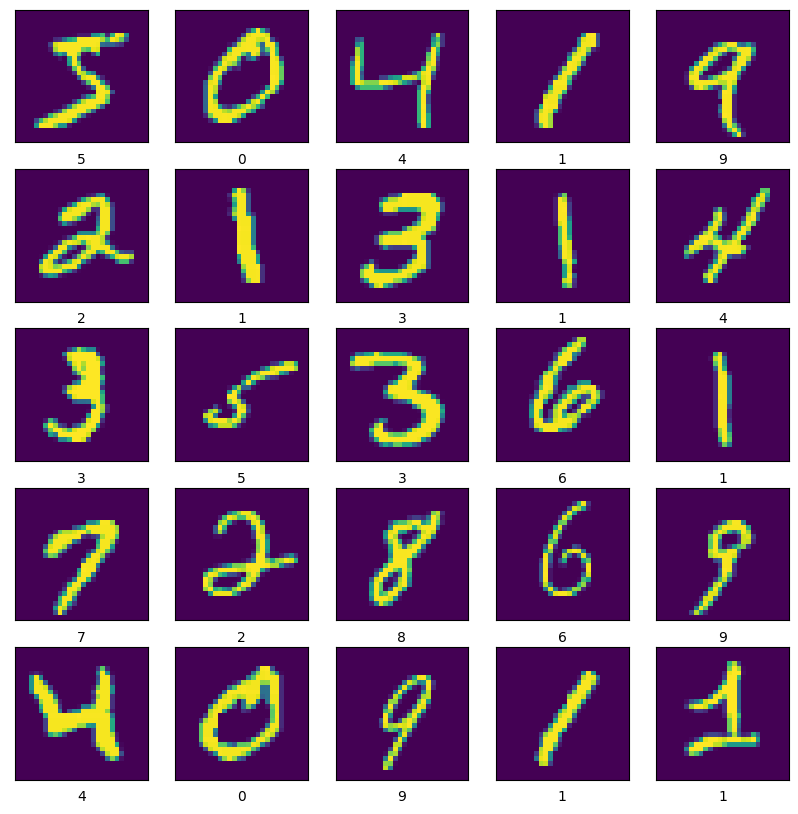

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(y_train[i])
plt.show()

### Run a CNN (convolutional neural network)
To better understand image classification, we will first approach the problem classically. We will run a simple CNN which has 2 convolutional layers and will classify, on average, to 98%. Briefly, a convolution layer is an integral transform which detects certain features using a filter to pass over the image.
<img src="./_images/convolutionalfilter.gif">

In [253]:
# Tensorboard callback
%load_ext tensorboard

# Specify Folders
current_time = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
train_log_dir = 'logs/tensorboard/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
path_for_checkpoint_callback = 'logs/summary/'+current_time

# Create callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                log_dir=train_log_dir, histogram_freq=1, profile_batch=3
            )

# Model Checkpoint callback
model_ckpt =  tf.keras.callbacks.ModelCheckpoint(
                path_for_checkpoint_callback, save_weights_only=True
            )

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2022-11-28 15:51:08.570851: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-28 15:51:08.570896: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-11-28 15:51:08.571267: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [7]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model


cmodel = create_classical_model()
cmodel.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.002),
               metrics=[tf.keras.metrics.CategoricalAccuracy()])

cmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [8]:
cmodel.fit(x_train,
          y_train_onehot,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test[:1000], y_test_onehot[:1000]),
          callbacks=[tensorboard_callback,model_ckpt])

cnn_results = cmodel.evaluate(x_test, y_test_onehot)

Epoch 1/10
  2/469 [..............................] - ETA: 1:15 - loss: 2.2449 - categorical_accuracy: 0.1484

2022-11-28 06:22:09.306342: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-28 06:22:09.306386: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-11-28 06:22:09.480195: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-11-28 06:22:09.481137: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


  4/469 [..............................] - ETA: 1:21 - loss: 2.0278 - categorical_accuracy: 0.2871

2022-11-28 06:22:09.510728: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: logs/tensorboard/20221128-062207/plugins/profile/2022_11_28_06_22_09/jupyter-rickyyoung-40qbraid-2ecom.xplane.pb


469/469 [==============================] - ETA: 0s - loss: 0.1987 - categorical_accuracy: 0.9392

2022-11-28 06:23:18.658915: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


469/469 [==============================] - 71s 150ms/step - loss: 0.1987 - categorical_accuracy: 0.9392 - val_loss: 0.0408 - val_categorical_accuracy: 0.9850
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.0776 - categorical_accuracy: 0.9768

2022-11-28 06:24:30.139855: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


469/469 [==============================] - 71s 152ms/step - loss: 0.0776 - categorical_accuracy: 0.9768 - val_loss: 0.0324 - val_categorical_accuracy: 0.9890
Epoch 3/10
325/469 [===================>..........] - ETA: 20s - loss: 0.0579 - categorical_accuracy: 0.9823

KeyboardInterrupt: 

### Analysis of classical layers using Tensorboard
We will use tensorboard to analyze the results

In [9]:
y_pred = cmodel.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred, y_test)

313/313 [==============================] - 3s 8ms/step
[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

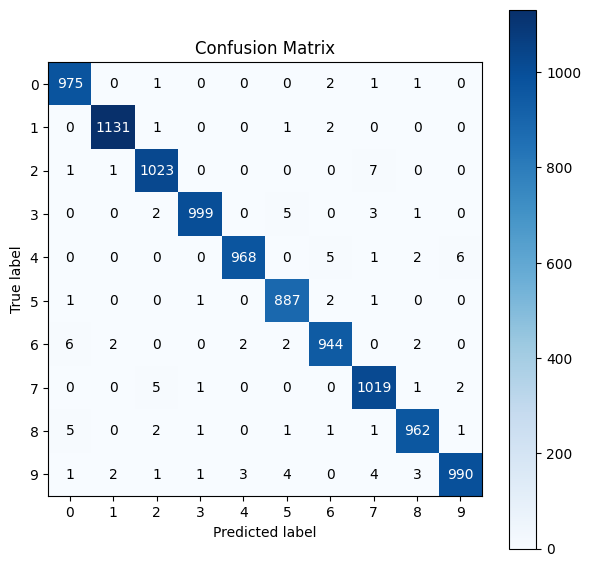

In [10]:
fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(y_test, y_pred, ax=ax)

What we see here is that the model can properly classify images incredibly well with a classical CNN. Let's see how we can do the same using quantum computing.

## Quantum Computing and it's proposed benefits and limitations
Using a quantum computer for machine learning and 

### Current challenge: embedding the circuit
During the NISQ era, there are severe limitations with how to encoding the images onto a quantum register for gate based implementations. For MNIST, the full image cannot be encoded into a quantum register; therefore, downsampling techniques are used to reduce the image size.

- How many qubits are needed



## Preprocess the MNIST dataset for quantum computing
For this demo, we will only apply one classical preprocessing technique and different embedding techniques. This is a non-standard process since embedding techniques can vary in # of qubits,

Further we will keep the quantum layers to be the same for each of the embedding processes.

There is some empty space around the image so we will first remove it.

In [106]:
# Crop and remove border from image
x_train_crop = np.array([x.reshape(28,28)[3:27,3:27] for x in x_train])
x_test_crop =np.array([x.reshape(28,28)[3:27,3:27] for x in x_test])

# Add channel dimension to dataset for resizing [ batch, height, width, channel]
x_train_crop = x_train_crop[..., np.newaxis]
x_test_crop = x_test_crop[..., np.newaxis]

# Resize image to fit on register
x_train_256 = tf.image.resize(x_train_crop, [16,16]).numpy()
x_test_256 = tf.image.resize(x_test_crop, [16,16]).numpy()

# Confirm dataset is still correct batch and shape
print(f'The batch size is: {len(x_train_256)} images')
print(f'Image height and width: {x_train_256[10].shape}')

2022-11-28 06:51:42.391116: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 276480000 exceeds 10% of free system memory.


The batch size is: 60000 images
Image height and width: (16, 16, 1)


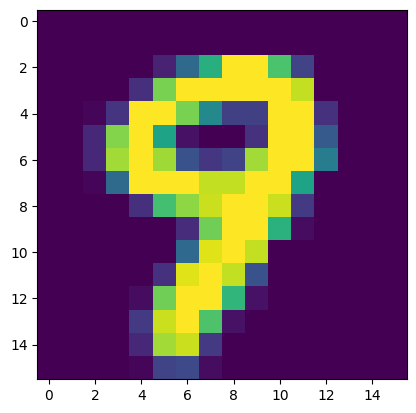

In [18]:
plt.imshow(x_train_256[5999])

### Methods of embedding the image into a circuit

First we need to pre-process the data to ensure it can be embedded.

In [19]:
#constants
wires=8


#### Angle Embedding
Basis embedding applies the 

#### Amplitude Embedding
With amplitude embedding we will encode $2^n$ features where $n$ represents the number of qubits. 

In [203]:
# we will develop the embedding circuit
dev = qml.device('default.qubit', wires=wires)


def amm_strategy(wires): 
    """
    All-qubit Multi-observable Measurement (AMM) strategy applies pauli operators 
    X, Y, Z on all qubits to extract features from disentangled quantum state
    (Zeng et al.).
    """
    readout = []
    # Applies pauli
    for i in range(8):
        readout.append(qml.expval(qml.PauliX(i)))
        readout.append(qml.expval(qml.PauliY(i)))
        readout.append(qml.expval(qml.PauliZ(i)))            
    return  readout
    
@qml.qnode(dev)
def quantum_layer(inputs,weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(8), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(8))
    return amm_strategy(wires)

In [204]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=8)
weights = np.random.random(size=shape)
print(weights.shape)
print(qml.draw(quantum_layer)(x_train_256[0].flatten(), weights))

(1, 8, 3)
0: ─╭AmplitudeEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>
1: ─├AmplitudeEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>
2: ─├AmplitudeEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>
3: ─├AmplitudeEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>
4: ─├AmplitudeEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>
5: ─├AmplitudeEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>
6: ─├AmplitudeEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>
7: ─╰AmplitudeEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <X>  <Y>  <Z>


In [217]:
weight_shapes = {"weights": (1,8,3) }
qlayer = qml.qnn.KerasLayer(quantum_layer, weight_shapes, output_dim=24)

In [218]:
# Build the Keras model.
qmodel = tf.keras.Sequential([
# The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Flatten(),
    qlayer,
    tf.keras.layers.Dense(10, activation='softmax')
])

In [219]:
qmodel.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(0.02))
qmodel.build(input_shape=[32,16,16,1])

In [220]:
qmodel.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_38 (Flatten)        (32, 256)                 0         
                                                                 
 keras_layer_14 (KerasLayer)  (32, 24)                 0 (unused)
                                                                 
 dense_45 (Dense)            (32, 10)                  250       
                                                                 
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________


In [223]:
qnn_history = qmodel.fit(x_train_256[:1000],
          y_train_onehot[:1000],
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test_256[:1000], y_test_onehot[:1000]),
          callbacks=[tensorboard_callback,model_ckpt])

Epoch 1/5
 2/32 [>.............................] - ETA: 8:12 - loss: 2.3089 - categorical_accuracy: 0.1562

2022-11-28 07:17:47.436878: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-28 07:17:47.436915: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-11-28 07:18:05.378529: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-11-28 07:18:06.902900: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-11-28 07:18:06.910648: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: logs/tensorboard/20221128-062207/plugins/profile/2022_11_28_07_18_06/jupyter-rickyyoung-40qbraid-2ecom.xplane.pb


32/32 [==============================] - 722s 23s/step - loss: 2.1618 - categorical_accuracy: 0.3240 - val_loss: 1.9892 - val_categorical_accuracy: 0.4600
Epoch 2/5
32/32 [==============================] - 716s 23s/step - loss: 1.8810 - categorical_accuracy: 0.5380 - val_loss: 1.7160 - val_categorical_accuracy: 0.5240
Epoch 3/5
32/32 [==============================] - 709s 22s/step - loss: 1.6577 - categorical_accuracy: 0.5940 - val_loss: 1.5347 - val_categorical_accuracy: 0.5580
Epoch 4/5
32/32 [==============================] - 708s 22s/step - loss: 1.4897 - categorical_accuracy: 0.6500 - val_loss: 1.4347 - val_categorical_accuracy: 0.5920
Epoch 5/5
32/32 [==============================] - 709s 22s/step - loss: 1.3664 - categorical_accuracy: 0.6550 - val_loss: 1.3542 - val_categorical_accuracy: 0.6080


In [224]:
qnn_results = qmodel.evaluate(x_test_256, y_test_onehot)

313/313 [==============================] - 2072s 7s/step - loss: 1.3231 - categorical_accuracy: 0.6471


In [226]:
y_pred = qmodel.predict(x_test_256)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred, y_test)

313/313 [==============================] - 2081s 7s/step
[7 5 1 ... 9 6 6] [7 2 1 ... 4 5 6]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

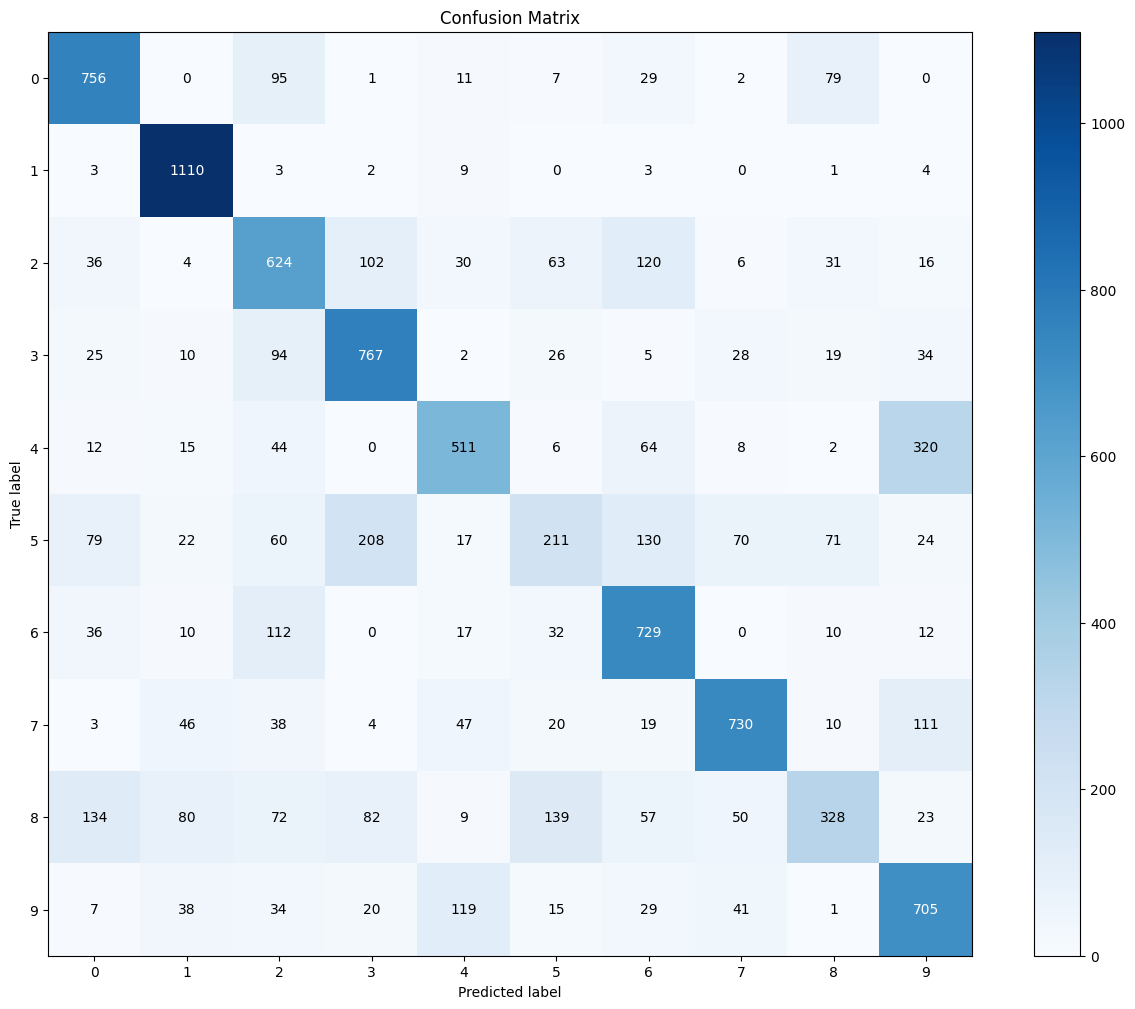

In [227]:
fig, ax = plt.subplots(figsize=(16,12))
plot_confusion_matrix(y_test, y_pred, ax=ax)

#### Other Technique from a paper

### Other techniques (kernel methods etc).

### Running a model


#### Analysis of current implementations using Tensorboard and qBraid SDK

In [ ]:
%tensorboard --logdir logs

## Other methods, kernel methods

In [228]:
# Build the Keras model.
fair_model = tf.keras.Sequential([
# The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [229]:
fair_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(0.02))
fair_model.build(input_shape=[32,16,16,1])

In [230]:
fair_model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_39 (Flatten)        (32, 256)                 0         
                                                                 
 dense_46 (Dense)            (32, 10)                  2570      
                                                                 
Total params: 2,570
Trainable params: 2,570
Non-trainable params: 0
_________________________________________________________________


In [231]:
fair_model_history = fair_model.fit(x_train_256[:1000],
          y_train_onehot[:1000],
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test_256[:1000], y_test_onehot[:1000]),
          callbacks=[tensorboard_callback,model_ckpt])

Epoch 1/5
 3/32 [=>............................] - ETA: 1s - loss: 2.3645 - categorical_accuracy: 0.1354 

2022-11-28 14:08:33.399756: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-28 14:08:33.399794: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-11-28 14:08:33.461467: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-11-28 14:08:33.462872: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-11-28 14:08:33.471374: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: logs/tensorboard/20221128-062207/plugins/profile/2022_11_28_14_08_33/jupyter-rickyyoung-40qbraid-2ecom.xplane.pb


32/32 [==============================] - 1s 14ms/step - loss: 1.0584 - categorical_accuracy: 0.6730 - val_loss: 0.6978 - val_categorical_accuracy: 0.7760
Epoch 2/5
32/32 [==============================] - 0s 6ms/step - loss: 0.4302 - categorical_accuracy: 0.8810 - val_loss: 0.6343 - val_categorical_accuracy: 0.7930
Epoch 3/5
32/32 [==============================] - 0s 6ms/step - loss: 0.3243 - categorical_accuracy: 0.9170 - val_loss: 0.4940 - val_categorical_accuracy: 0.8400
Epoch 4/5
32/32 [==============================] - 0s 6ms/step - loss: 0.2697 - categorical_accuracy: 0.9310 - val_loss: 0.4788 - val_categorical_accuracy: 0.8450
Epoch 5/5
32/32 [==============================] - 0s 6ms/step - loss: 0.2213 - categorical_accuracy: 0.9500 - val_loss: 0.4719 - val_categorical_accuracy: 0.8530


In [232]:
fair_results = fair_model.evaluate(x_test_256, y_test_onehot)

313/313 [==============================] - 0s 952us/step - loss: 0.4367 - categorical_accuracy: 0.8667


In [239]:
y_fair_pred = fair_model.predict(x_test_256)
y_fair_pred = np.argmax(y_fair_pred, axis=1)
print(y_test, y_fair_test)

313/313 [==============================] - 0s 860us/step
[7 2 1 ... 4 5 6] [7 2 1 ... 9 5 6]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

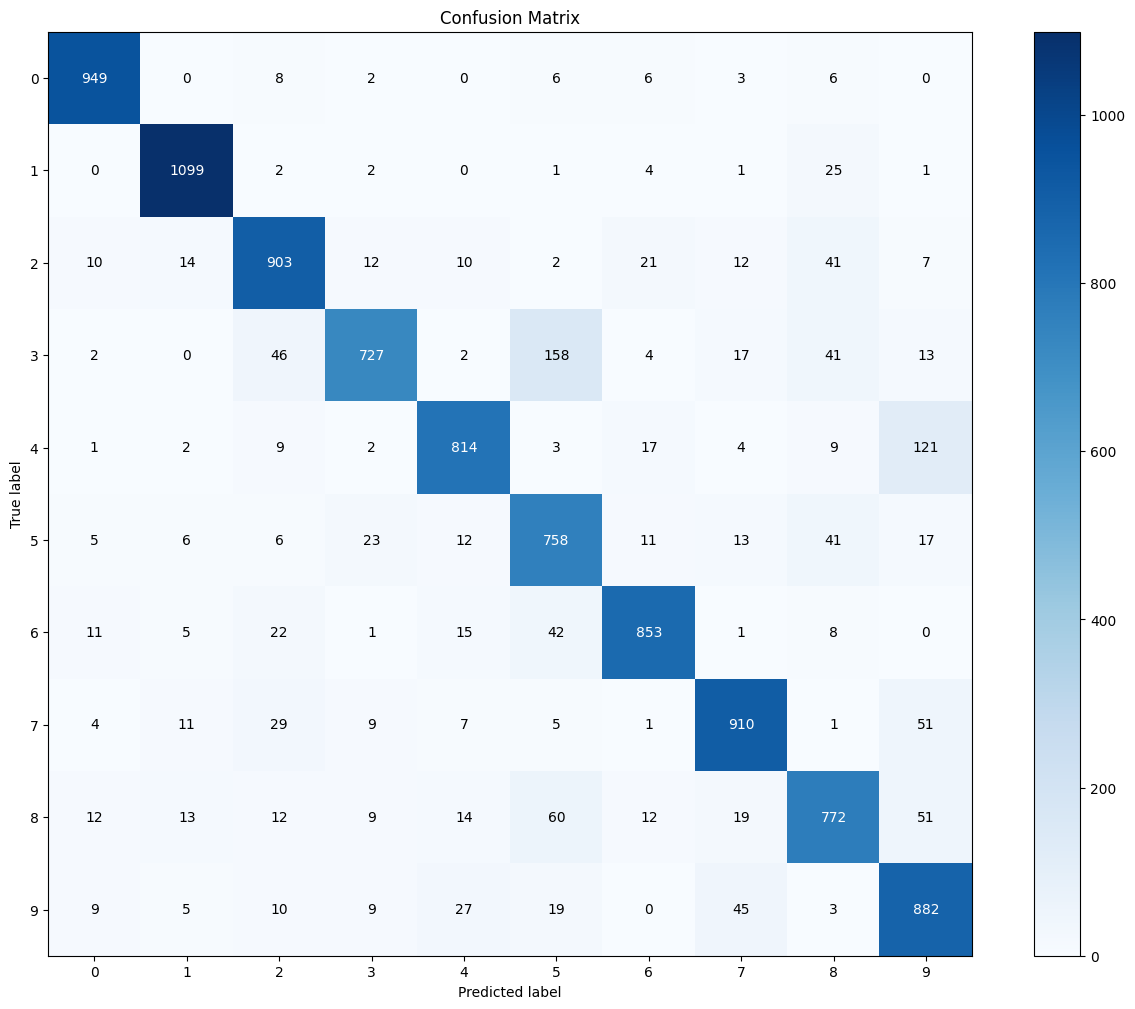

In [240]:
fig, ax = plt.subplots(figsize=(16,12))
plot_confusion_matrix(y_test, y_fair_pred, ax=ax)

In [263]:
%tensorboard --logdir logs/

In [261]:
!kill 31185